<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/DanielCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import cv2
from PIL import Image
import os
 
import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

In [2]:
def loadImages(path):
    # list with paths of all images in the folder
    f_paths = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    # list with file names of the images
    f_names = [ os.path.basename(i) for i in f_paths ]
    # list with images
    # images = [ cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in files_path ] # cv read takes too long!
    images = [ plt.imread(i) for i in f_paths ]

    return f_names, images


def loadAnnotations(path):
  table = pd.read_csv(path)
  # file_names = list(table[['file_name']])
  f_names = [x[0] for x in table.values] #read colum 0
  annotations = np.asarray(table[['annotation']]).ravel()
  return f_names, annotations
 

def buildDataset(f_names, annotations, img_names, images):
  img_set = [] # empty list
  for i in range(len(f_names)):
    img_dict = {} # empty dictionary
    try:
      # find image name in annotation file
      idx = f_names.index(img_names[i])
      # create dictionary and add it to the list
      img_dict['file_name'] = f_names[i]
      img_dict['annotation'] = annotations[i]
      img_dict['image'] = images[i]
      img_set.append(img_dict)
    except:
      print("Image " + img_names[i] + " not found in annotations file!")
  
  return img_set


def reduceImages(images, imgNewSz):
  #Reduce the images by pixel size
  reduced_images = []
  for i in images:
    rimg = cv2.resize(i, (imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
    # rimg = cv2.resize(i, None, fx=ratio, fy=ratio, interpolation = cv2.INTER_AREA)
    reduced_images.append(rimg)

  reduced_images = np.array(reduced_images)
  return reduced_images


# Histogram equalization
# https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def histEqualization(dataset):
  equ_dataset = dataset # copy input dataset
  for n in range(len(dataset)):
    # convert to YUV
    img_yuv = cv2.cvtColor(dataset[n]['image'], cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    equ_dataset[n]['image']  = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  return equ_dataset


def countClasses(dataset):
  labels = np.asarray( [d['annotation'] for d in dataset] )
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("") # enter


def countLabels(labels):
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("") # enter

In [3]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Retrieve original images
data_path = "drive/My Drive/ECE_542-Project_1/TrainingData"
img_names, images = loadImages(data_path)

# Get annotation csv file
annotations_path = os.path.join(data_path, 'Annotations.csv')
f_names, labels = loadAnnotations(annotations_path)

# Build dictionary with data
dataset = buildDataset(f_names, labels, img_names, images)
print("Initial count")
countClasses(dataset)

# Preprocess images using histogram equalization
# uncomment next line to apply histogram equalization to all the dataset
# dataset = histEqualization(dataset)


Initial count
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275



{'file_name': '000479.jpg', 'annotation': 3, 'image': array([[[ 97, 118,  99],
        [103, 137, 112],
        [ 92, 138, 102],
        ...,
        [ 60,  83,  67],
        [ 66,  87,  70],
        [ 65,  87,  66]],

       [[ 84, 109,  88],
        [ 93, 127, 103],
        [ 96, 139, 109],
        ...,
        [ 64,  81,  71],
        [ 71,  89,  77],
        [ 74,  88,  73]],

       [[ 57,  81,  65],
        [ 89, 118, 100],
        [ 95, 131, 105],
        ...,
        [ 70,  91,  76],
        [ 84, 102,  90],
        [106, 119, 109]],

       ...,

       [[ 35,  42,  24],
        [ 37,  44,  26],
        [ 38,  47,  28],
        ...,
        [ 92, 108,  79],
        [112, 134, 111],
        [120, 145, 123]],

       [[ 34,  45,  28],
        [ 34,  46,  26],
        [ 35,  47,  25],
        ...,
        [ 70,  84,  61],
        [103, 122, 103],
        [108, 133, 112]],

       [[ 30,  47,  29],
        [ 31,  46,  25],
        [ 33,  49,  23],
        ...,
        [ 57,  70,  

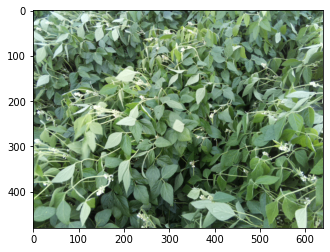

In [5]:
#Display an image from dataset
sampleID = 19
plt.imshow(dataset[sampleID]['image'])
print(dataset[sampleID])

In [6]:
# Test dataset

print("Before Split")
countClasses(dataset)

# Extract the same number of samples for the test dataset
n_samples = 20;
test_dataset = [] # start with empty set
for a in range(5):
  cnt = 0
  for i in dataset:
    if i['annotation']==a and cnt<n_samples:
      test_dataset.append(i)
      cnt += 1
# Update dataset
dataset = [i for i in dataset if i not in test_dataset]

print("After Split")
countClasses(dataset)


Before Split
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275

After Split
Class 0: 468
Class 1: 309
Class 2: 110
Class 3: 111
Class 4: 177
 Total : 1175



In [7]:
# Data Augmentation Schemes

# uncomment scheme in the generator to add it
datagen = ImageDataGenerator(
	rotation_range=10,
	# zoom_range=0.15, # [1-zoom_range,1+zoom_range]
	# width_shift_range=0.2,
	# height_shift_range=0.2,
	# shear_range=0.15,
  # brightness_range=[0.4,1.5],
	horizontal_flip=True,
	fill_mode="reflect") #  nearest

# Resize images
img_size = 224
images = np.array( [ d['image'] for d in dataset ] ) # extract images from dataset
images  = reduceImages(images, img_size)

# Replace images in the dataset
for d in range(len(dataset)):
  dataset[d]['image'] = images[d]

# Batch size to generate images
b_size = 468
# Total images per class
img_total = 900

# Emtpy lists
images = []
labels = []

for c in range(5): # 5 classes
  # Extract images and labels from the clases
  imgs = np.array( [ d['image'] for d in dataset if d['annotation']==c ] )
  lbls = np.array( [ d['annotation'] for d in dataset if d['annotation']==c ] )

  batches = 0
  for gen_imgs, gen_lbls in datagen.flow(imgs, lbls,  batch_size=b_size):
    # add data to the lists
    images.extend(gen_imgs) 
    labels.extend(gen_lbls)
    print("C=%d: %d" %(c,len(images)) )
    # print(len(images))
    # print(len(labels))
    batches += 1
    if len(images) >= img_total*(c+1):  #int(img_total/b_size):  # 10 batches
      # we need to break the loop by hand because
      # the generator loops indefinitely
      break


C=0: 468
C=0: 936
C=1: 1245
C=1: 1554
C=1: 1863
C=2: 1973
C=2: 2083
C=2: 2193
C=2: 2303
C=2: 2413
C=2: 2523
C=2: 2633
C=2: 2743
C=3: 2854
C=3: 2965
C=3: 3076
C=3: 3187
C=3: 3298
C=3: 3409
C=3: 3520
C=3: 3631
C=4: 3808
C=4: 3985
C=4: 4162
C=4: 4339
C=4: 4516


In [8]:
# Check agumented data

# Convert to uint8
images = [ img.astype('uint8') for img in images ]

# convert to np arrays
images = np.asarray(images)
labels = np.asarray(labels)

print(images.shape)
print(labels.shape)
countLabels(labels)

(4516, 224, 224, 3)
(4516,)
Class 0: 936
Class 1: 927
Class 2: 880
Class 3: 888
Class 4: 885
 Total : 4516



In [9]:
# Randomnize dataset
dataset_list = list(zip(images, labels))
np.random.shuffle(dataset_list)
images, labels = zip(*dataset_list)
images = np.asarray(images)
labels = np.asarray(labels)
print(labels)

[2 0 2 ... 4 0 0]


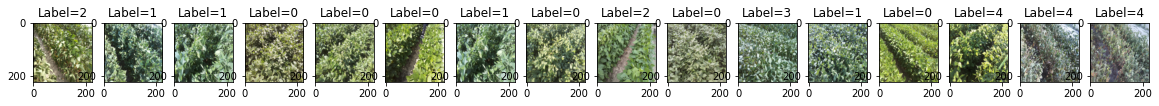

In [10]:
# Plotting 16 random images
Num = 16
N = np.random.randint(0,len(images), Num) 
# Plot
fig, axes = plt.subplots(1, Num, figsize=(20,3))
ax = axes.ravel()
for i in range(Num):
  ax[i].imshow(images[N[i]])
  title = "Label=" + str(labels[N[i]])
  ax[i].title.set_text(title)

In [11]:

#Keeping 40% for Validation
valid_set_pc = 0.3
split= int((len(images))*(1-valid_set_pc))

#labels = annotations[['annotation']]
validX = images[split:]
validY = labels[split:]
 
trainX = images[:split]
trainY = labels[:split]

#Convert from integers to floats
images = images.astype('float32')
trainX = trainX.astype('float32')
validX = validX.astype('float32')
 
# Normalize to range 0-1
images = images / 255.0
trainX = trainX / 255.0
validX = validX / 255.0

print('images=%s, min=%.3f, max=%.3f' % (images.shape, images.min(), images.max()))
print(labels.shape)

print('trainX=%s, min=%.3f, max=%.3f' % (trainX.shape, trainX.min(), trainX.max()))
print(trainY.shape)

print('validX=%s, min=%.3f, max=%.3f' % (validX.shape, validX.min(), validX.max()))
print(validY.shape)

images=(4516, 224, 224, 3), min=0.000, max=1.000
(4516,)
trainX=(3161, 224, 224, 3), min=0.000, max=1.000
(3161,)
validX=(1355, 224, 224, 3), min=0.000, max=1.000
(1355,)


In [12]:
print(np.unique(labels), np.unique(trainY), np.unique(validY))
# Compute class weights. Useful for unbalanced datasets
c_weights = class_weight.compute_class_weight('balanced',
                                               np.unique(trainY),
                                               trainY).tolist()
# Create dictionary
c_weights = { i : c_weights[i] for i in range(0, len(c_weights) ) }
print(c_weights)

[0 1 2 3 4] [0 1 2 3 4] [0 1 2 3 4]
{0: 0.9741140215716487, 1: 0.9987361769352291, 2: 1.01152, 3: 0.989358372456964, 4: 1.0279674796747968}


In [13]:
# One-hot encoding of outputs
labels = to_categorical(labels)
trainY = to_categorical(trainY)
validY = to_categorical(validY)

In [14]:
# # Defining Base CNN Model
# def define_base_model(height, width, rate):
#     model = Sequential()
 
#     model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
#     #model.add(Dropout(rate))
#     #model.add(MaxPooling2D((2, 2)))
 
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(rate))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(rate))    
#     model.add(Dense(5, activation='softmax'))
 
#     return model


In [15]:
# Transfer learning

# loading the vgg16 model
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images
vgg = VGG16(input_shape=(img_size, img_size, 3), include_top=True) # True=include FC layers

# Freeze model
for layer in (vgg.layers)[:19]: # Freeze all convolutional layers
    print(layer)
    layer.trainable = False

# Replace vgg output layer
x= vgg.layers[-2].output
prediction = Dense(5, activation="softmax")(x) # 5 classes

# x = Flatten()(vgg.output)
# prediction = Dense(5, activation='softmax')(x) # 5 classes

# Creating instance
model = Model(inputs = vgg.input, outputs = prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])


# summarize the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [16]:
# Train the model
history = model.fit(trainX, trainY, epochs=20, validation_data=(validX, validY), class_weight=c_weights, verbose=1)

Epoch 1/20
99/99 [==============================] - 21s 212ms/step - loss: 2.6738 - categorical_accuracy: 0.4590 - val_loss: 0.8736 - val_categorical_accuracy: 0.6790
Epoch 2/20
99/99 [==============================] - 19s 195ms/step - loss: 0.5867 - categorical_accuracy: 0.7615 - val_loss: 0.4557 - val_categorical_accuracy: 0.8185
Epoch 3/20
99/99 [==============================] - 20s 203ms/step - loss: 0.4000 - categorical_accuracy: 0.8342 - val_loss: 0.4966 - val_categorical_accuracy: 0.7926
Epoch 4/20
99/99 [==============================] - 20s 206ms/step - loss: 0.2492 - categorical_accuracy: 0.8994 - val_loss: 0.5287 - val_categorical_accuracy: 0.7956
Epoch 5/20
99/99 [==============================] - 20s 201ms/step - loss: 0.2495 - categorical_accuracy: 0.9060 - val_loss: 0.3457 - val_categorical_accuracy: 0.8708
Epoch 6/20
99/99 [==============================] - 20s 199ms/step - loss: 0.1036 - categorical_accuracy: 0.9595 - val_loss: 0.4245 - val_categorical_accuracy: 0.857

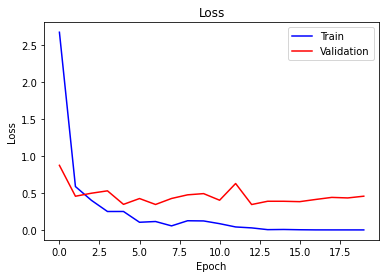

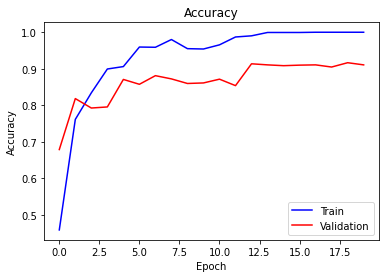

In [17]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
 
# Plotting results of training
plot_history(history)

In [18]:
# Fine tunning

# Freeze model
# vgg.trainable = True
# model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss=keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=[keras.metrics.BinaryAccuracy()])

# model.compile(loss='categorical_crossentropy',
#                     optimizer=Adam(learning_rate=0.00001),
#                     metrics=['categorical_accuracy'])

# history1 = model.fit(trainX, trainY, epochs=5, validation_data=(validX, validY), verbose=1)
# plot_history(history1)

In [19]:
# F1 Score
trueY = np.argmax(validY, axis=1)

# base_results = model.predict_classes(validX) # 'Functional' object has no attribute 'predict_classes'
base_results = model.predict(validX)
base_results = np.argmax(base_results,axis=1)

base_f1_score = f1_score(trueY, base_results, average=None)
print(base_f1_score)

[0.92631579 0.82149047 0.94716981 0.97425743 0.89393939]


In [20]:
# Test set

# extract images and labels from dataset
pre_test_images = [ d['image'] for d in test_dataset ]
pre_test_labels = [ d['annotation'] for d in test_dataset ]

# Measure performance on test set
pre_test_images = reduceImages(pre_test_images, img_size)
pre_test_results = model.predict(pre_test_images)
pre_test_results = np.argmax(pre_test_results,axis=1)

print(np.sum(pre_test_results == pre_test_labels)/len(pre_test_labels))
countLabels(pre_test_results)

0.3
Class 0: 20
Class 1: 1
Class 2: 67
Class 3: 5
Class 4: 7
 Total : 100



In [21]:
# F1 Score Test set
trueY = pre_test_labels
test_f1_score = f1_score(trueY, pre_test_results, average=None)
print(test_f1_score)

[0.65       0.0952381  0.34482759 0.         0.07407407]


In [22]:
# Generate CSV
test_path = "/content/drive/My Drive/ECE_542-Project_1/TestData-20201017T151905Z-001.zip"
 
zip1 = zipfile.ZipFile(test_path)
listOfFileNames1 = sorted(zip1.namelist())

# Remove 'Directory name'
file_name = []
for f in listOfFileNames1:
  file_name.append(f.replace('TestData/',''))
# print(file_name)
 
#Create array of test data
test = []
for file in listOfFileNames1:
  if file.endswith('.jpg'):
    img1 = plt.imread(zip1.open(file))
    test.append(img1)
  
test = np.array(test)

test_images = reduceImages(test, img_size)
# print(test_images.shape)
test_results = model.predict(test_images)
test_results = np.argmax(test_results,axis=1)

countLabels(test_results)

# Generate CSV file
data = {'file_name': file_name,'annotation': test_results  }
export_data = pd.DataFrame(data, columns=['file_name', 'annotation'])
export_data.to_csv (r'/content/drive/My Drive/ECE_542-Project_1/prediction.csv', index = False, header=True)
print(export_data)

Class 0: 23
Class 1: 2
Class 2: 79
Class 3: 6
Class 4: 90
 Total : 200

      file_name  annotation
0    020031.jpg           4
1    020244.jpg           2
2    020446.jpg           2
3    020597.jpg           4
4    020693.jpg           2
..          ...         ...
195  029650.jpg           4
196  029787.jpg           2
197  029841.jpg           0
198  029866.jpg           4
199  029897.jpg           4

[200 rows x 2 columns]
